# Visualizing results

In [31]:
cd /home

/home


In [32]:
import matplotlib.pyplot as plt 

import pandas as pd
import numpy as np
import toml
import wandb
import toml
import glob
import os

from src.utils import get_metrics

### Summary table

In [33]:
folder = './presentation/experiments/astromer_2/results/results/'
exp_folders = glob.glob(os.path.join(folder, '*', '*','pretraining'))

In [34]:
metric_names= ['epoch_loss', 'epoch_r_square', 'epoch_rmse', 'epoch_bce', 'epoch_acc']

rows = []
for expdir in exp_folders:
    config_path = os.path.join(expdir, 'config.toml')
    log_dir = os.path.join(expdir, 'logs')
    
    with open(config_path, 'r') as f:
        config = toml.load(f)
    
    try:
        val_metrics = get_metrics(os.path.join(log_dir, 'validation'), metric_name='epoch_loss')
        best_epoch = val_metrics['value'].astype(float).argmin() 

        for index, metric in enumerate(metric_names):
            try:
                train_metrics = get_metrics(os.path.join(log_dir, 'train'), metric_name=metric)
                valid_metrics = get_metrics(os.path.join(log_dir, 'validation'), metric_name=metric)

                config[metric] = np.round(train_metrics.iloc[best_epoch]['value'], 3)
                config[metric+'_val'] = np.round(valid_metrics.iloc[best_epoch]['value'], 3)        
            except:
                continue
        rows.append(pd.Series(config))
    except:
        continue
results = pd.concat(rows, axis=1).T
results.columns

Index(['exp_name', 'data', 'checkpoint', 'gpu', 'debug', 'encoder_mode',
       'layers', 'nh', 'hdim', 'pe_dim', 'mixer', 'dropout', 'avg_layers',
       'lr', 'bs', 'patience', 'epochs', 'ws', 'optimizer', 'off_nsp',
       'probed', 'rs', 'nsp_prob', 'rmse_factor', 'epoch_loss',
       'epoch_loss_val', 'epoch_r_square', 'epoch_r_square_val', 'epoch_rmse',
       'epoch_rmse_val', 'epoch_bce', 'epoch_bce_val', 'epoch_acc',
       'epoch_acc_val'],
      dtype='object')

In [35]:
def format_label(x):
    if x['data'].endswith('/'):
        x['data'] = x['data'][:-1]
            
    title = x['data'].split('/')[-1]
     
    label = 'Enc: {}\n Layers: {}\n Mixer: {}\n Dropout: {:.2f}\n RMSE a: {}\n AvgOut: {}\n Probed: {:.2f}\nData:{}'.format(x['encoder_mode'], x['layers'], 
                                                             x['mixer'], x['dropout'], x['rmse_factor'], 
                                                             x['avg_layers'], x['probed'], title)
    return label

results['tickname'] = results.apply(lambda x: format_label(x), 1) 
print(results.columns)

results[['rmse_factor', 'epoch_loss_val', 'epoch_bce_val', 'epoch_r_square']]

Index(['exp_name', 'data', 'checkpoint', 'gpu', 'debug', 'encoder_mode',
       'layers', 'nh', 'hdim', 'pe_dim', 'mixer', 'dropout', 'avg_layers',
       'lr', 'bs', 'patience', 'epochs', 'ws', 'optimizer', 'off_nsp',
       'probed', 'rs', 'nsp_prob', 'rmse_factor', 'epoch_loss',
       'epoch_loss_val', 'epoch_r_square', 'epoch_r_square_val', 'epoch_rmse',
       'epoch_rmse_val', 'epoch_bce', 'epoch_bce_val', 'epoch_acc',
       'epoch_acc_val', 'tickname'],
      dtype='object')


,rmse_factor,epoch_loss_val,epoch_bce_val,epoch_r_square
0,0.5,0.13,0.246,0.947
1,1.0,0.027,NaN,0.757
2,1.0,0.043,NaN,0.611
3,1.0,0.004,NaN,0.799


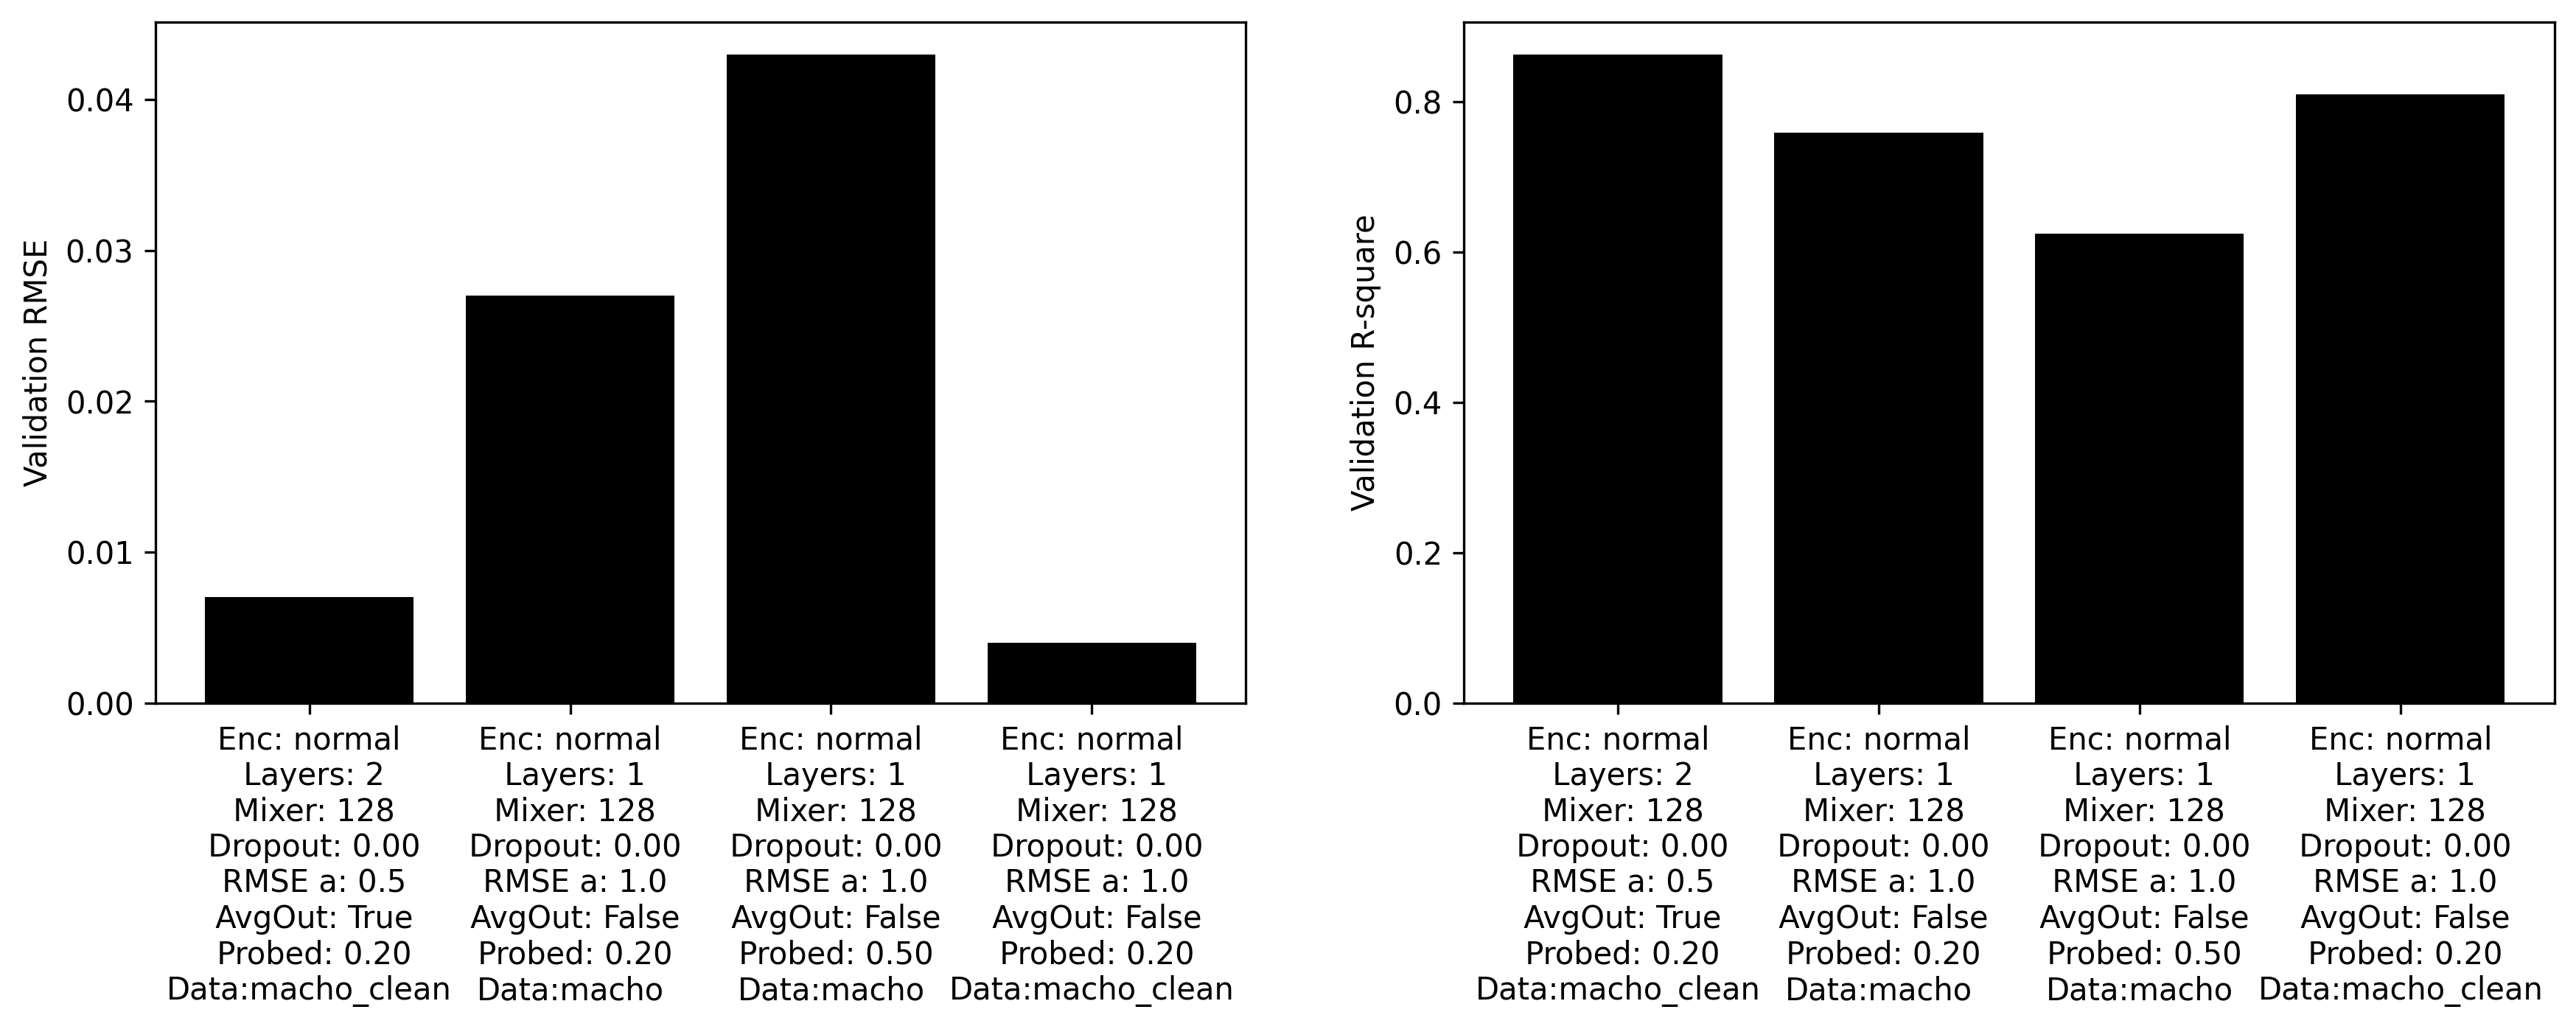

In [36]:
fig, axes = plt.subplots(1, 2, gridspec_kw={'hspace': 0., 'wspace': 0.2}, dpi=300, figsize=(14, 4))
axes = axes.flatten()
labels_name = {
    'epoch_loss_val': 'Validation Loss',
    'epoch_rmse_val': 'Validation RMSE',
    'epoch_r_square_val': 'Validation R-square',
    'epoch_acc': 'Validation Accuracy',
    'epoch_bce': 'Validation Binary \n Cross-Entropy',
    }

for i, column in enumerate(['epoch_rmse_val', 'epoch_r_square_val']):
    
    if 'rmse' in column:
        y = results['epoch_loss_val'] - results['epoch_bce_val'].fillna(0.)*0.5
    else:
        y = results[column]
        
    axes[i].bar(results['tickname'], y, color='k')
    axes[i].set_ylabel(labels_name[column])

## Testing results

In [37]:
import toml
root = './presentation/experiments/astromer_2/results/results/'

x_labels = []
rmse_values = []
r2_values = []
exp_folders = glob.glob(os.path.join(root, '*', '*','pretraining'))

for folder in exp_folders:
    try:
        with open(os.path.join(folder, 'config.toml'), 'r') as h:
            config = toml.load(h)
            info = format_label(config)
        with open(os.path.join(folder, 'metrics.toml'), 'r') as h:
            metrics = toml.load(h)
            x_labels.append(info)
            rmse_values.append(metrics['test_rmse'])
            r2_values.append(metrics['test_r2'])
    except Exception as e:
        continue

Text(0, 0.5, 'Test R-square')

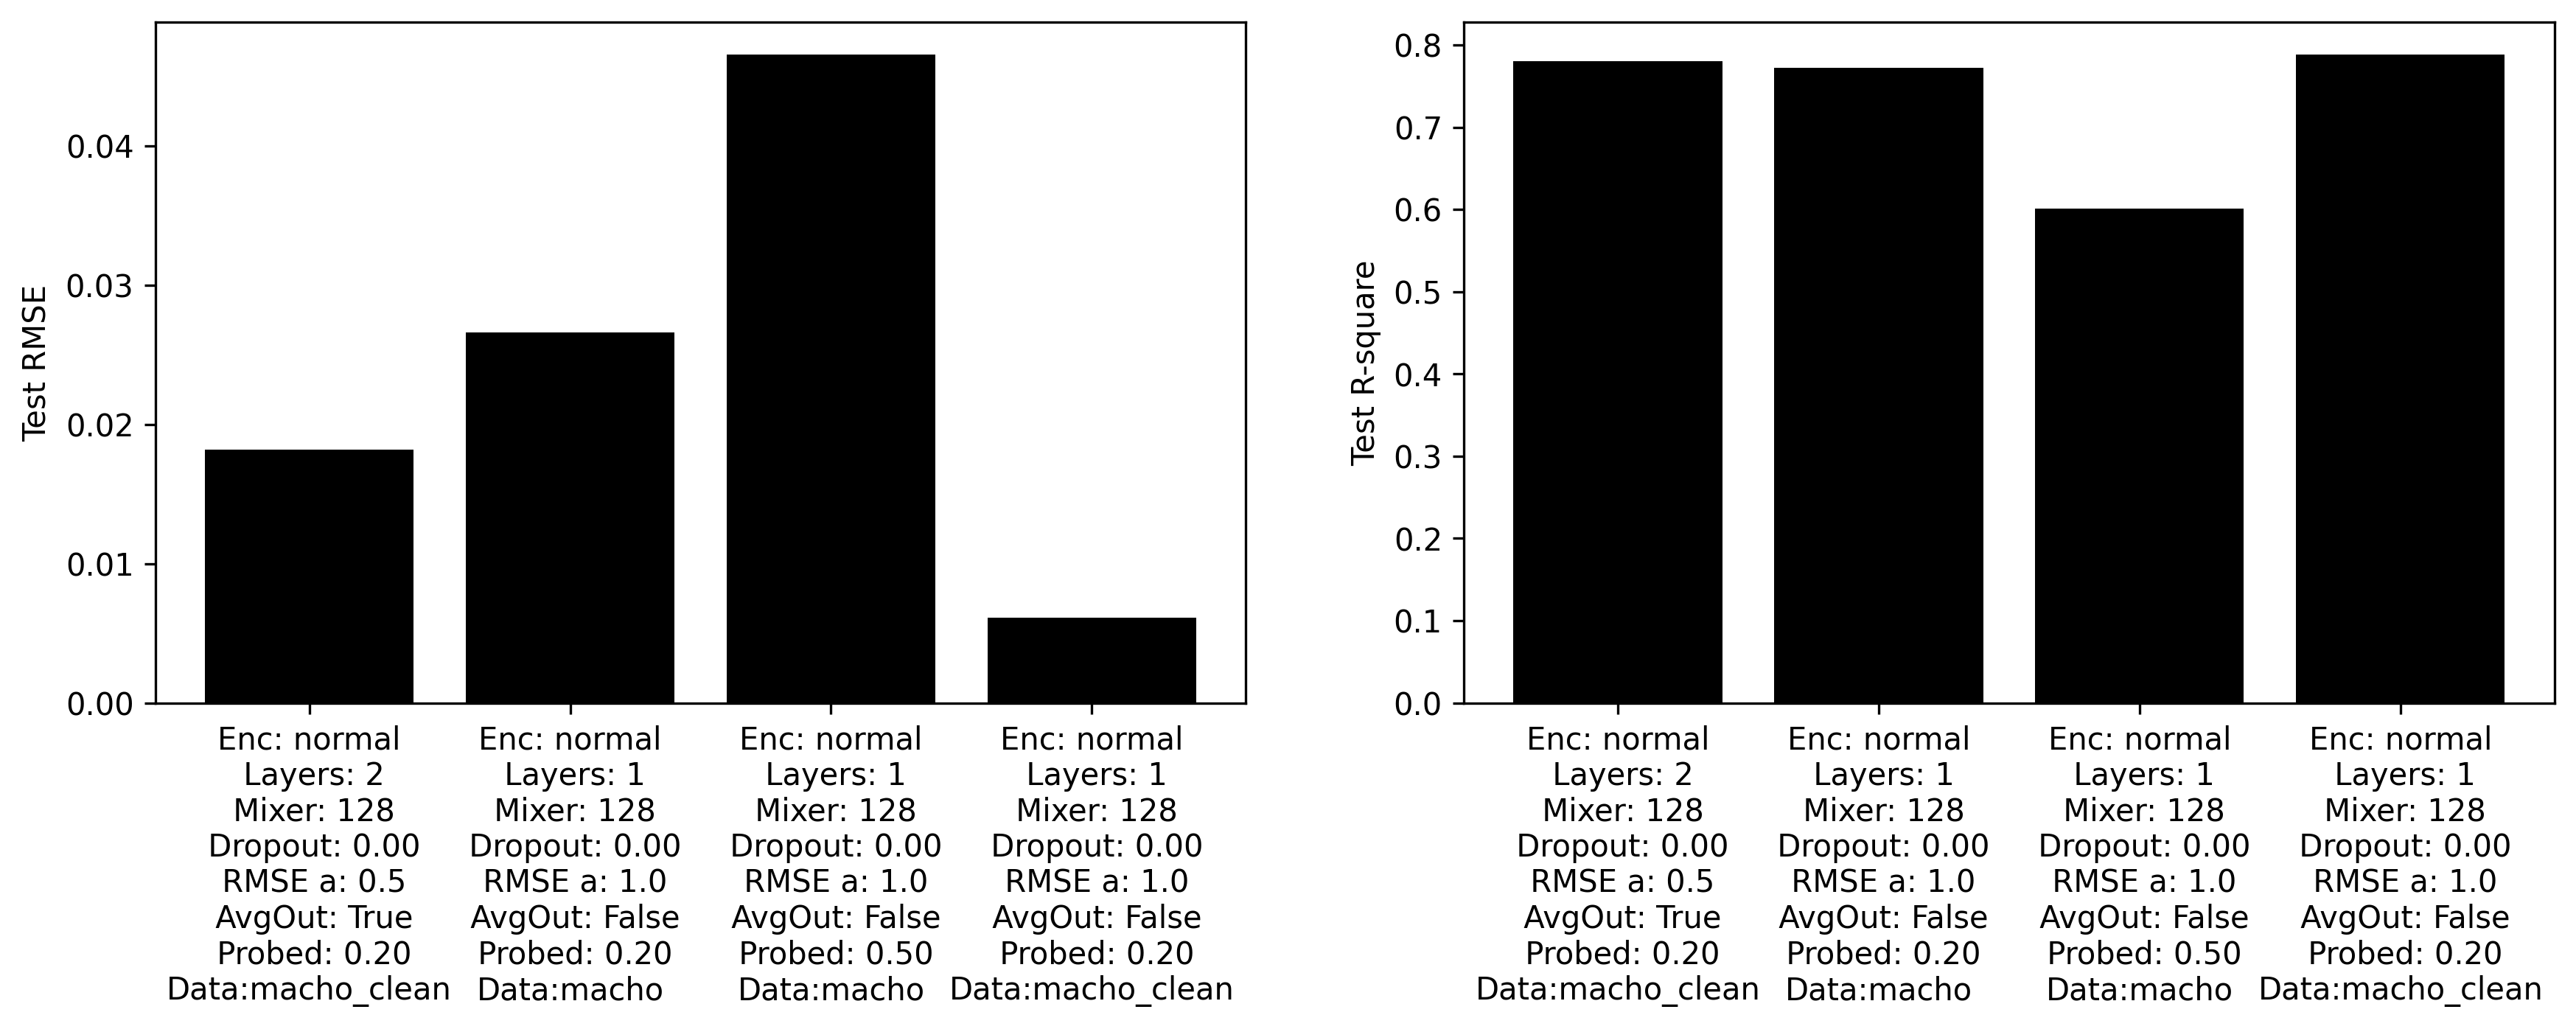

In [38]:
fig, axes = plt.subplots(1, 2, gridspec_kw={'hspace': 0., 'wspace': 0.2}, dpi=300, figsize=(14, 4))
axes[0].bar(x_labels, rmse_values, color='k')
axes[1].bar(x_labels, r2_values, color='k')
axes[0].set_ylabel('Test RMSE')
axes[1].set_ylabel('Test R-square')

### Visualize learning curves

In [110]:
def name_pt_model(folder_name):
    if folder_name == '2023-08-25_20-44-55':
        return 'Astromer-I\n 20% probed\n Clean'
    if folder_name == '2023-08-25_20-44-47':
        return 'Astromer-I\n 20% probed'
    if folder_name == '2023-08-26_23-27-37':
        return 'Astromer-I\n 50% probed'
    if folder_name == '2023-08-28_17-53-10':
        return 'Astromer II\n 20% probed\n Clean ($\lambda$=0.5)'

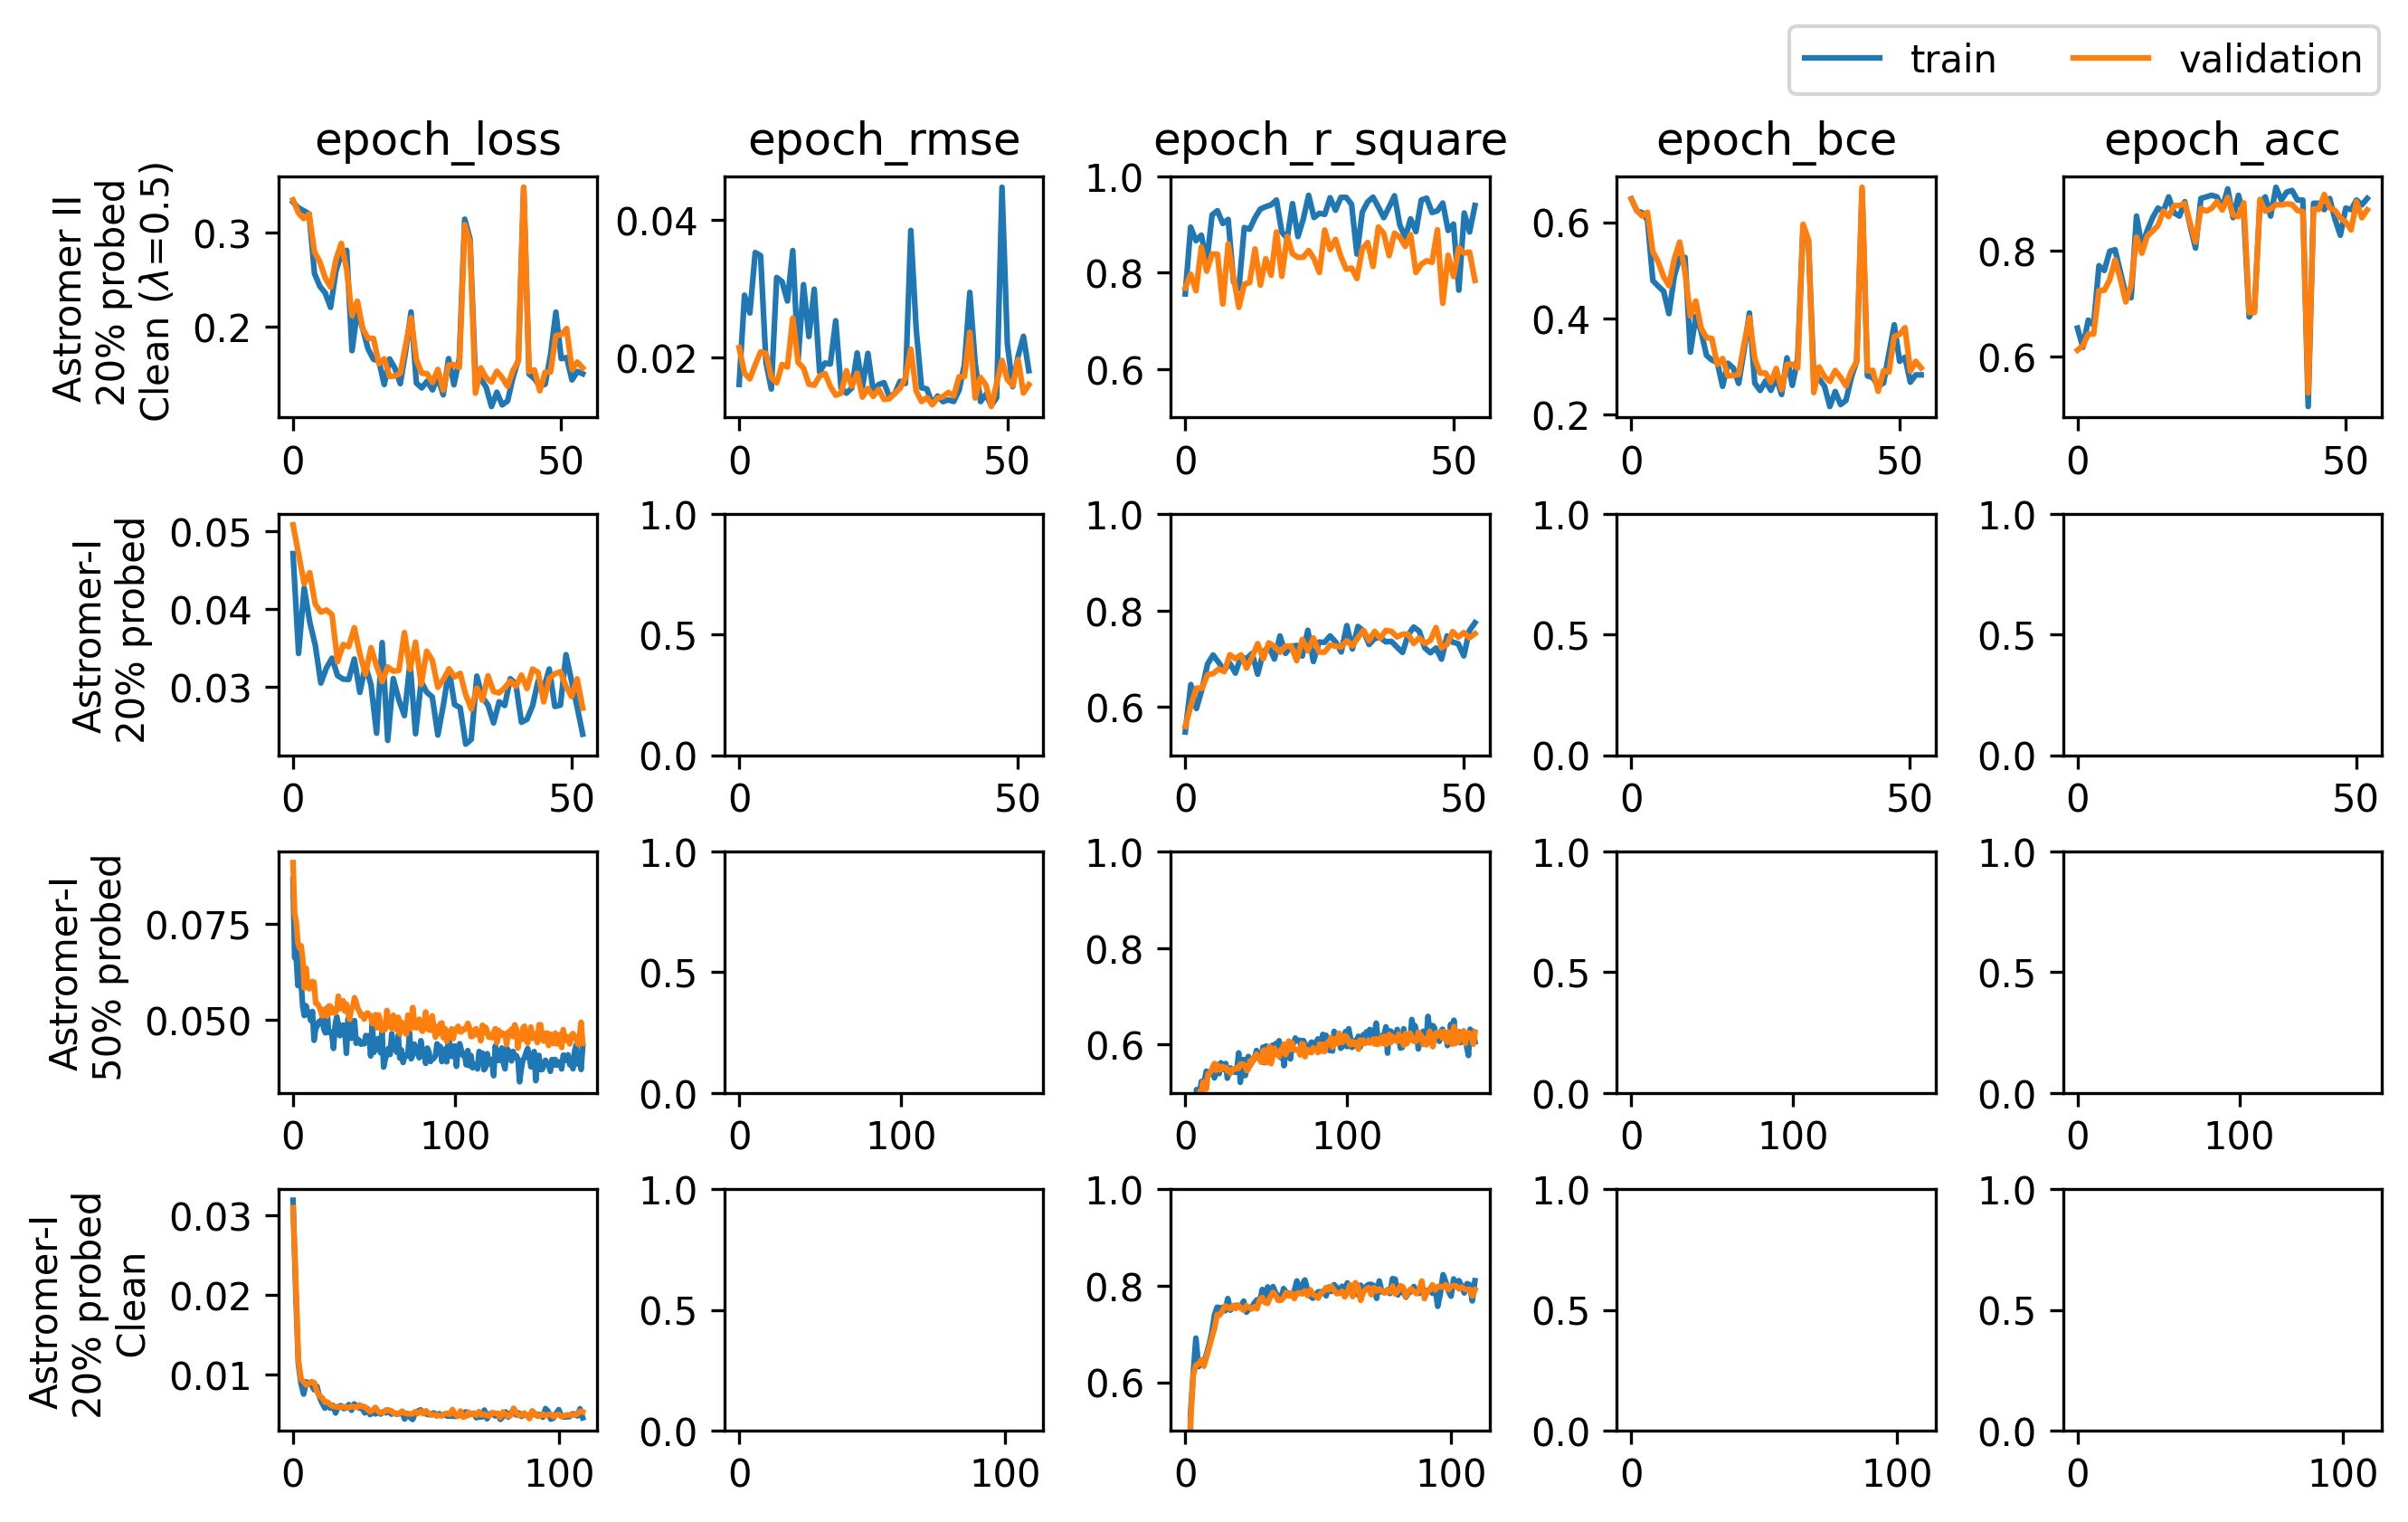

In [111]:
logs_path = './presentation/experiments/astromer_2/results/results/'

exp_folders = glob.glob(os.path.join(logs_path, '*', '*','pretraining', 'logs'))

metric_names= ['epoch_loss', 'epoch_rmse', 'epoch_r_square', 'epoch_bce', 'epoch_acc']
# metric_names= ['epoch_loss', 'epoch_r_square']

fig, axes = plt.subplots(len(exp_folders), 5, figsize=(10,6), dpi=300, 
                        gridspec_kw={'hspace': 0.4, 'wspace': 0.4}, sharex='row')

for row, exp_path in enumerate(exp_folders):
    exp_title = name_pt_model(exp_path.split('/')[7])
    axes[row][0].set_ylabel(exp_title)
    for col, metric_name in enumerate(metric_names):
        try:
            train_metrics = get_metrics(os.path.join(exp_path, 'train'), metric_name=metric_name)
            valid_metrics = get_metrics(os.path.join(exp_path, 'validation'), metric_name=metric_name)
            axes[row][col].plot(train_metrics['value'], label='train')
            axes[row][col].plot(valid_metrics['value'], label='validation')
            axes[0][col].set_title(metric_name)
        except Exception as e:
            continue

    axes[row][2].set_ylim(0.5, 1)
axes[0][-1].legend(bbox_to_anchor=(1.05, 1.7), ncols=2)

### Classification results

In [112]:
astromer_0 = pd.read_csv('./presentation/experiments/astromer_0/backup/wandb_tables/downstream.csv')

In [113]:
files = ['./presentation/experiments/astromer_2/results/results/clf_20.csv',
         './presentation/experiments/astromer_2/results/results/clf_50.csv']

sum_pandas = []
for f in files:
    summary = pd.read_csv(f)
    summary = summary[summary['State'] == 'finished']
    sum_pandas.append(summary)
summary = pd.concat(sum_pandas)
summary.shape

(144, 53)

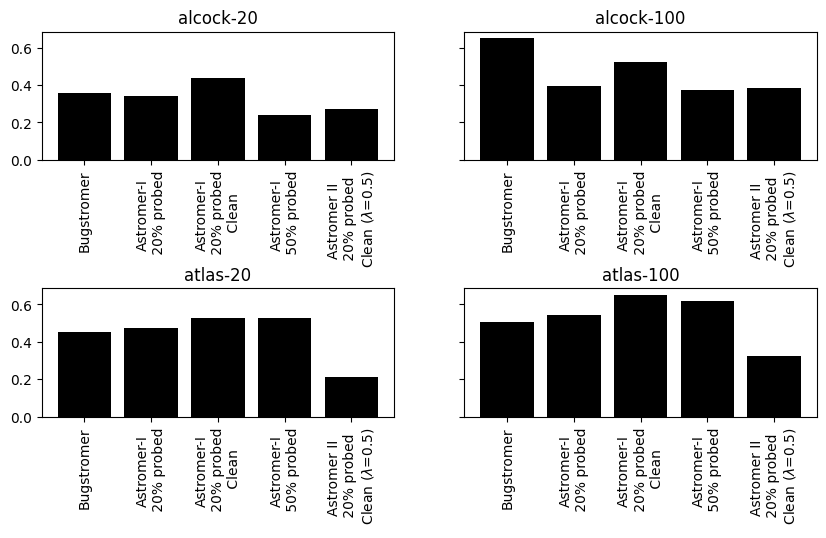

In [114]:
fig, axes = plt.subplots(2, 2, figsize=(10,5), gridspec_kw={'hspace': 1, 'wspace': 0.2}, sharey=True)
color_dict = ['darkred', 'darkgreen']
for i, (subdataset_name, subframe) in enumerate(summary.groupby('subdataset')):
    offset = 0.
    subframe = subframe[subframe['clf_name'] == 'mlp_att']
    for j, (spc, subframe_2) in enumerate(subframe.groupby('spc')):    
        
        # ======
        astromer_old = pd.read_csv('./presentation/experiments/astromer_0/backup/errata/results/paper/{}/classification/metrics.csv'.format(subdataset_name))
        acc_old = astromer_old[(astromer_old['model'] == 'mlp_att') & \
                               (astromer_old['spc'] == spc) & \
                               (astromer_old['sci_case'] == 'b')][['test_f1']].mean().values[0]
        
        
        subgroups = subframe_2.groupby(['clf_name', 'pt_model'])
        metrics = subgroups[['clf_test_f1', 'clf_test_acc']].mean().reset_index()

        single = metrics[metrics['clf_name'] == 'mlp_att']
        values = list(single['clf_test_f1'].values)
        values = [acc_old] + values
        
        xticks = [name_pt_model(x.split('/')[0]) for x in single['pt_model'].values]
        xticks = ['Bugstromer'] + xticks

        axes[i][j].bar(xticks, values, color='k')
        axes[i][j].set_xticks(range(len(xticks)))
        axes[i][j].set_xticklabels(xticks, rotation=90)
        axes[i][j].set_title('{}-{}'.format(subdataset_name, spc))
        offset+=0.2
        
